Import libraries and define k

In [365]:
import numpy as np
import cupy as cp
import time

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Read data and split it to train and test sets. Define k.

In [366]:
k = 3

data = np.loadtxt( "MLoGPU_data1_train.csv", delimiter = ",", dtype = np.float32 )

n_test = int( 0.2*data.shape[0] )

x_data = np.array( data[ :, 0:-1 ] )
y_data = np.array( data[ :, -1 ] ).reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split( x_data, y_data, test_size = n_test, stratify = y_data )

print( X_test.shape)

(800, 10)


Defining kernel code

In [367]:
l2distance = cp.RawKernel(r"""
  extern "C" __global__ 
  void euclidean_distance( float* a, float* b, float* c, int vec_length, int vec_num) {

    int thread_index = blockIdx.x * blockDim.x + threadIdx.x;
    float term_diff = 0;
    float difference = 0;
    
    if ( thread_index > vec_num  ) {
      return;
    }

    for ( int ii = 0; ii < vec_length; ++ii ) {
      
      term_diff = 0;

      int vec_index = vec_length*thread_index + ii;
    
      term_diff = b[ii] - a[ vec_index ];
      difference += term_diff*term_diff;
      
      __syncthreads();

    }
    c[ thread_index ] = sqrtf( difference );
  }
""", "euclidean_distance")

Defining constants and block and grid dims

In [368]:
N_training = X_train.shape[0]
N_features = X_train.shape[1]

if N_training < 1024:
    numThreadsNeeded = N_training
else:
    numThreadsNeeded = 1024

numBlocks = np.int32( np.ceil( N_training / numThreadsNeeded ) )

block_dims = ( numThreadsNeeded, 1, 1 )
grid_dims = ( numBlocks, 1, 1 )



Doing the classification

In [369]:
# Move data to device
training_vecs_gpu = cp.asarray( X_train )
distances = cp.zeros( [ N_training, 1 ], dtype = np.float32 )
predictions_gpu = np.zeros( ( X_test.shape[0], 1 ), dtype = np.int16 )

# Initializing erformance measurements
distance_times = np.zeros( ( X_test.shape[0], 1 ), dtype = np.float64 )
start_time = time.perf_counter()

# For each vector
for ii in range( X_test.shape[0] ):
    
    test_vec = X_test[ ii, : ]
    test_vec_gpu = cp.asarray( test_vec )

    # Executing the kernel
    dist_time = time.perf_counter()
    l2distance( grid_dims, block_dims, ( training_vecs_gpu, test_vec_gpu, distances, N_features, N_training ) )
    distance_times[ii] = time.perf_counter() - dist_time
    
    # Sorting the distances 
    distance_data = cp.concatenate( ( distances, cp.asarray( Y_train ) ), axis = 1 )
    
    ind = cp.argsort( distance_data[ :, 0 ] )
    sorted_distances = distance_data[ ind ]
    
    kNearest = sorted_distances[ 0:k, 1 ]
    unique, counts = cp.unique( kNearest, return_counts = True )
    
    label_ind = cp.argsort( counts )[-1]
    predicted_label = unique[ label_ind ]
        
    predictions_gpu[ii] = np.int16( predicted_label.get() )
    
time_GPU = round( ( time.perf_counter() - start_time ), 3 )

print( "Average calculation time of the distances for a test vector: ", np.mean( distance_times ) )

Average calculation time of the distances for a test vector:  2.8508499744930305e-05


Visualizing and evaluating results

[[  0   0   0   1   1   1   0]
 [  0   3   8  11   4   2   0]
 [  0   6 142  61  19   9   0]
 [  0   4  65 197  71  18   0]
 [  0   0   3  57  76  11   0]
 [  0   0   0   9  10  10   0]
 [  0   0   0   1   0   0   0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.23      0.11      0.15        28
         5.0       0.65      0.60      0.62       237
         6.0       0.58      0.55      0.57       355
         7.0       0.42      0.52      0.46       147
         8.0       0.20      0.34      0.25        29
         9.0       0.00      0.00      0.00         1

    accuracy                           0.54       800
   macro avg       0.30      0.30      0.29       800
weighted avg       0.54      0.54      0.54       800



c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

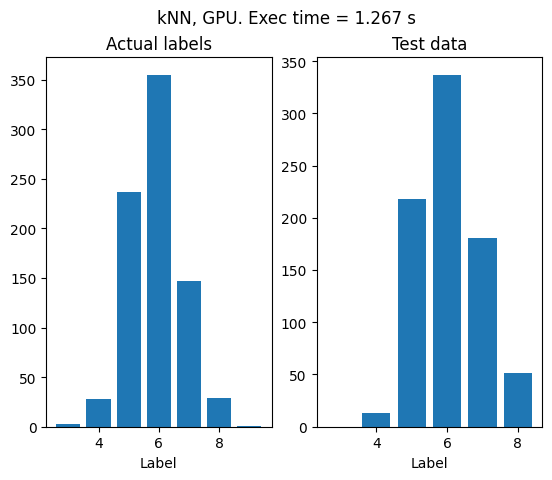

In [370]:
unique_labels = np.unique( data[ :, -1 ] )

Y_test_bins = np.bincount( np.squeeze( Y_test ).astype( np.int16 ) )[3:]
predicted_bins = np.bincount( np.squeeze( predictions_gpu ) )[3:]

fig, axarr = plt.subplots(1,2)

axarr[0].bar( unique_labels[ 0:len( Y_test_bins )], Y_test_bins ) 
titlestr = 'Actual labels'
axarr[0].set_title( titlestr )
axarr[0].set( xlabel = 'Label' )

axarr[1].bar( unique_labels[ 0:len( predicted_bins ) ], predicted_bins )
titlestr = 'Test data'
axarr[1].set_title( titlestr )
axarr[1].set( xlabel = 'Label' )

titlestr = "kNN, GPU. Exec time = " + str( time_GPU ) + " s"
fig.suptitle( titlestr )

print( confusion_matrix( Y_test, predictions_gpu ) )
print( classification_report( Y_test, predictions_gpu ) )

Implementation using CPU for comparison

Average calculation time of the distances for a test vector:  6.271287391427904e-05
[[  0   0   0   1   1   1   0]
 [  0   3   8  11   4   2   0]
 [  0   6 142  61  19   9   0]
 [  0   4  65 197  71  18   0]
 [  0   0   3  57  76  11   0]
 [  0   0   0   9  10  10   0]
 [  0   0   0   1   0   0   0]]
              precision    recall  f1-score   support

         3.0       0.00      0.00      0.00         3
         4.0       0.23      0.11      0.15        28
         5.0       0.65      0.60      0.62       237
         6.0       0.58      0.55      0.57       355
         7.0       0.42      0.52      0.46       147
         8.0       0.20      0.34      0.25        29
         9.0       0.00      0.00      0.00         1

    accuracy                           0.54       800
   macro avg       0.30      0.30      0.29       800
weighted avg       0.54      0.54      0.54       800



c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\erikk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

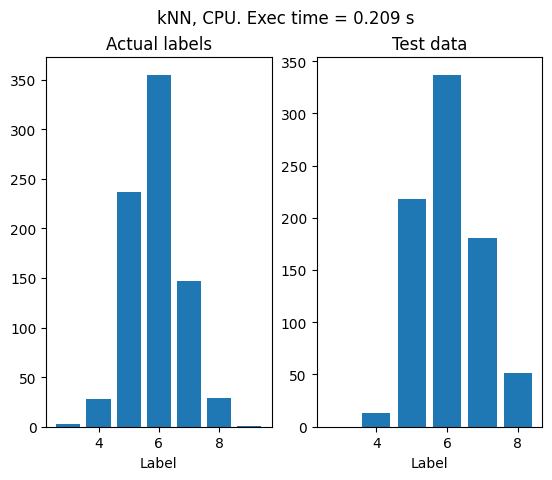

In [371]:
predictions_cpu = np.zeros( ( X_test.shape[0], 1 ), dtype = np.int16 )

# Initializing erformance measurements
start_time = time.perf_counter()
distance_times = np.zeros( ( X_test.shape[0], 1 ), dtype = np.float64 )

# For each test vector
for ii in range( X_test.shape[0] ):
    
    test_vec = X_test[ ii, : ]

    # Calculating the distances
    dist_time = time.perf_counter()
    distances = np.linalg.norm( X_train - test_vec, axis = 1 ).reshape(-1, 1)
    distance_times[ii] = time.perf_counter() - dist_time

    # Sorting the distances 
    distance_data = np.concatenate( ( distances, Y_train ), axis = 1 )
    
    ind = np.argsort( distance_data[ :, 0 ] )
    sorted_distances = distance_data[ ind ]
    
    kNearest = sorted_distances[ 0:k, 1 ]
    unique, counts = np.unique( kNearest, return_counts = True )
    
    label_ind = np.argsort( counts )[-1]
    predicted_label = unique[ label_ind ]
        
    predictions_cpu[ii] = predicted_label 
    
time_CPU = round( ( time.perf_counter() - start_time ), 3 )
print( "Average calculation time of the distances for a test vector: ", np.mean( distance_times ) )

predicted_bins = np.bincount( np.int64( np.squeeze( predictions_cpu ) ) )[3:]

time_CPU = round( ( time.perf_counter() - start_time ), 3 )

fig, axarr = plt.subplots(1,2)

# Visualizing and evaluation
axarr[0].bar( unique_labels[ 0:len( Y_test_bins )], Y_test_bins ) 
titlestr = 'Actual labels'
axarr[0].set_title( titlestr )
axarr[0].set( xlabel = 'Label' )

axarr[1].bar( unique_labels[ 0:len( predicted_bins ) ], predicted_bins )
titlestr = 'Test data'
axarr[1].set_title( titlestr )
axarr[1].set( xlabel = 'Label' )

titlestr = "kNN, CPU. Exec time = " + str( time_CPU ) + " s"
fig.suptitle( titlestr )

print( confusion_matrix( Y_test, predictions_cpu ) )
print( classification_report( Y_test, predictions_cpu ) )